In [47]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

%matplotlib inline 

# Raw Data Pre-processing and Sanity Check

This data set offers insight into the history of the summer and winter Olympic games from the Athens 1986 Games to the Rio 2016 Games. The raw data set has 15 columns listed below and 271,116 rows corresponding to individual athletes competing in an Olympic event.<br>

__ID__ - Unique number for each athlete, type: int64 <br>
__Name__ - Athlete's name, type: object<br>
__Sex__ - Male or Female, type: object<br>
__Age__ - Age of athlete, type: float64 <br>
__Height__ - Height of athlete, in centimetres, type: float64 <br>
__Weight__ - Weight of athlete, in kilograms, type: float64 <br>
__Team__ - Team name, type: object<br>
__NOC__ - National Olympic Committee: 3-letter code corresponding to country came (in separate file provided), type: object <br>
__Games__ - Year and season, type: object <br>
__Year__ - Year, type: int64 <br>
__Season__ - Summer or Winter, type: object <br>
__City__ - Host city, type: object <br>
__Sport__ - Sport type (i.e Swimming), type: object <br>
__Event__ - Particular event of a given sport type (i.e Swimming Men's 400 metres Freestyle), type: object <br>
__Medal__ - Gold, Silver, Bronze, or NAN, type: object. <br>

In [48]:
# Load data
# main olympic histoty file:
data = pd.read_csv('all_data/athlete_events.csv')
data.name ='Olympic_Data'
# supplemntary file, containing a maping form country codes to regions:
regions = pd.read_csv('all_data/noc_regions.csv') 
regions.name = 'Regions_2_Country'

In [49]:
data[data['Sport']=='Swimming'].head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
29,10,"Einar Ferdinand ""Einari"" Aalto",M,26.0,NaN,NaN,Finland,FIN,1952 Summer,1952,Summer,Helsinki,Swimming,Swimming Men's 400 metres Freestyle,NaN
35,15,Arvo Ossian Aaltonen,M,22.0,NaN,NaN,Finland,FIN,1912 Summer,1912,Summer,Stockholm,Swimming,Swimming Men's 200 metres Breaststroke,NaN
36,15,Arvo Ossian Aaltonen,M,22.0,NaN,NaN,Finland,FIN,1912 Summer,1912,Summer,Stockholm,Swimming,Swimming Men's 400 metres Breaststroke,NaN
37,15,Arvo Ossian Aaltonen,M,30.0,NaN,NaN,Finland,FIN,1920 Summer,1920,Summer,Antwerpen,Swimming,Swimming Men's 200 metres Breaststroke,Bronze
38,15,Arvo Ossian Aaltonen,M,30.0,NaN,NaN,Finland,FIN,1920 Summer,1920,Summer,Antwerpen,Swimming,Swimming Men's 400 metres Breaststroke,Bronze


In [50]:
regions[regions.NOC =='TCH'] 

,NOC,region,notes
197,TCH,Czech Republic,NaN


In [51]:
# rename 'region' to 'Country'
regions.rename(columns={"region": "Country"},inplace=True)

## Examine Missing Data 

In [52]:
def nan_data(data):
    tot = data.isnull().sum().sort_values(ascending = False)
    perc = round((data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False))
    print('Missing data in {} Data Frame:'.format(data.name))
    return pd.concat([tot, perc], axis=1, keys=['Total_Missing', 'Percent'])
nan_data(data).head(6)

Missing data in Olympic_Data Data Frame:


,Total_Missing,Percent
Medal,231333,85.0
Weight,62875,23.0
Height,60171,22.0
Age,9474,3.0
Event,0,0.0
Sport,0,0.0


Unsurprisingly, medals have NaN values where no medal was won. This should be replaced by another string, like 'No Medal".
As far as the other features with NaN values, more exploration is needed to understand how to best handle these. In case of the body metric features, the % of data missing may be too high to attempt to extrapolate. The Age variable has a much smaller % of data points missing. 

In [53]:
data['Medal'].fillna('No_Medal',inplace=True)

In [54]:
assert (data['Medal'].isnull().sum() == 0)

In [55]:
nan_data(regions)[1:].head(6)

Missing data in Regions_2_Country Data Frame:


,Total_Missing,Percent
Country,3,1.0
NOC,0,0.0


In [56]:
regions[regions['Country'].isnull()]

,NOC,Country,notes
168,ROT,NaN,Refugee Olympic Team
208,TUV,NaN,Tuvalu
213,UNK,NaN,Unknown


In [57]:
regions['Country'].fillna(regions['notes'],inplace=True)

In [58]:
assert (regions['Country'].isnull().sum() == 0)

So now the regions data frame has no NaN values and the main data frame has no NaN values in the Medals column. Before dealing with the NaNs in the Age and Body Metric Columns I will have a look data duplicates and other data issues. This is because I would like to use some form of interpolation on the remaining NaN variables, thus I would like to have a relatively clean dataset before proceeding. 

## Examine duplicates 

In [59]:
data[data.duplicated(keep=False)].head(4) # see some duplicated rows 

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
1251,704,Dsir Antoine Acket,M,27.0,NaN,NaN,Belgium,BEL,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",No_Medal
1252,704,Dsir Antoine Acket,M,27.0,NaN,NaN,Belgium,BEL,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",No_Medal
4281,2449,William Truman Aldrich,M,48.0,NaN,NaN,United States,USA,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Painting, Drawings And ...",No_Medal
4282,2449,William Truman Aldrich,M,48.0,NaN,NaN,United States,USA,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Painting, Drawings And ...",No_Medal


In [60]:
data[data.duplicated(keep='first')].ID.count()
# number of duplicated values is abour 0.5% of data size, so not critical and could be dropped 

1385

In [61]:
data[data.duplicated(keep=False)]['Year'].unique() 
# duplicates occur in the distant past (between 1900 and 1948)

array([1932, 1928, 1936, 1924, 1948, 1908, 1900])

In [62]:
# explore susspicion that duplicates only in Art Competitions, but turns out not only 
data[data.duplicated(keep=False)]['Sport'].unique() 

array(['Art Competitions', 'Cycling', 'Sailing', 'Equestrianism'],
      dtype=object)

In [63]:
# drop duplicats 
data.drop_duplicates(inplace=True)

In [64]:
assert (data.duplicated().sum()== 0)

## Examine relationship between NOC, Team and Country columns

In [65]:
# are NOC codes linked to unique teams? -No, France NOC associated woth 160 teams etc...
data.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head(10)

FRA    160
USA     97
GBR     96
SWE     52
NOR     46
GER     43
ITA     36
CAN     32
GRE     29
DEN     29
Name: NOC, dtype: int64

In [66]:
data[data['NOC']=='FRA']['Team'].unique()[:10] # inspect few instances of Teams with FRA code 

array(['France', 'France-1', 'France-2',
       'Union des Socits Franais de Sports Athletiques', 'France-3',
       'Martha-27', 'Martha-1', 'Socit Nautique de Bayonne',
       'Cupidon Viking', 'Damoiselle'], dtype=object)

In [67]:
data[data['NOC']=='USA']['Team'].unique()[:10] # inspect few instances of Teams with USA code 

array(['United States', 'Vesper Boat Club', 'New York Athletic Club #2-4',
       'Mystery', 'United States-1', 'United States-2',
       'Mound City Rowing Club-2', 'La Salle Turnverein, Chicago',
       'Gallant', 'United States-3'], dtype=object)

In general can see that the above are French / US teams

In [68]:
data.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().tail(1)

ROT    1
Name: NOC, dtype: int64

In [69]:
data[data['NOC']=='SYR']['Team'].unique()

array(['Syria'], dtype=object)

For certain countries, the 'Team' column is synonymous with the country name and in other cases, such as France or USA the 'Team' column gives specifics of the team name. Thus, the 'Team' column cannot reliably serve as a proxy for Country. Instead the regions data frame can be added to the main data frame to carry this information. This is done below. 

In [70]:
merged = pd.merge(data, regions, on='NOC', how='left')

In [71]:
merged.isnull().sum() # have unexpected NaNs in Country column after the merge

ID              0
Name            0
Sex             0
Age          9315
Height      58814
Weight      61527
Team            0
NOC             0
Games           0
Year            0
Season          0
City            0
Sport           0
Event           0
Medal           0
Country       349
notes      264696
dtype: int64

In [72]:
merged[merged.Country.isnull()].head(2) # looks like the culprit is team Singapore with NOC code SGP

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country,notes
578,332,Zarinah Abdullah,F,21.0,NaN,NaN,Singapore,SGP,1992 Summer,1992,Summer,Barcelona,Badminton,Badminton Women's Singles,No_Medal,NaN,NaN
579,332,Zarinah Abdullah,F,25.0,NaN,NaN,Singapore,SGP,1996 Summer,1996,Summer,Atlanta,Badminton,Badminton Women's Singles,No_Medal,NaN,NaN


In [73]:
merged[merged.Country.isnull()]['NOC'].unique()

array(['SGP'], dtype=object)

In [74]:
regions[regions.NOC == 'SGP']

,NOC,Country,notes


In [75]:
regions[regions.Country == 'Singapore']

,NOC,Country,notes
178,SIN,Singapore,NaN


So Singapore has two NOC codes: SIN with a correct country name and SGP with a NaN Country name. 
Action: Overwrite country code to SIN and fill Country with 'Singapore':

In [76]:
merged.Country.fillna('Singapore',inplace=True)
merged.NOC.replace('SGP','SIN',inplace=True)

In [77]:
merged.loc[:, ['NOC', 'Country']].drop_duplicates()['NOC'].value_counts().head(2) # all codes unique to country 

PLE    1
AUT    1
Name: NOC, dtype: int64

In [78]:
# CLEAN UP : can drop the 'notes' column
merged.drop('notes',axis=1,inplace=True)

## Fill Missing Data in Age, Height and Weight 

#### Start by further exploring and visualising the available Age, Height and Weight data:

Make plots to look at trends in the Age, Height and Weight variables with time and gender 

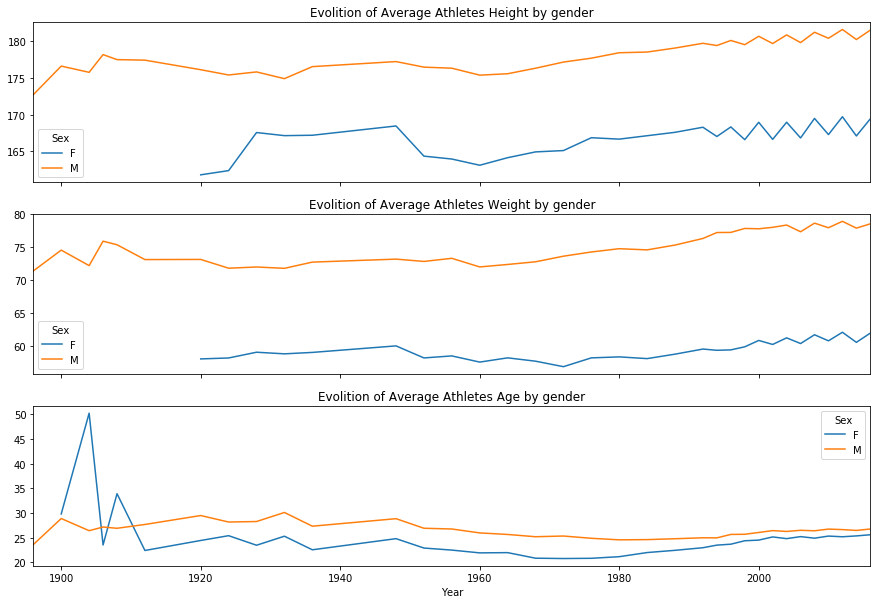

In [79]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, sharex=True)
ax1.set_title('Evolition of Average Athletes Height by gender')
merged.groupby(['Year', 'Sex'])['Height'].mean().unstack().plot(ax=ax1)
ax2.set_title('Evolition of Average Athletes Weight by gender')
merged.groupby(['Year', 'Sex'])['Weight'].mean().unstack().plot(ax=ax2)
ax3.set_title('Evolition of Average Athletes Age by gender')
merged.groupby(['Year', 'Sex'])['Age'].mean().unstack().plot(ax=ax3,figsize=(15,10))
plt.show()

__Observe:__<br>
- Clearly, Age/ Height/ Weight differ with gender.
- Since the 1960s Height/ Weight follow an upward trend.
- There are no values for Female Height or Weight before 1920, however some values for Age exists. Therefore, it is likely that a large proportion of the missing Height/Weight data if from early Olympiads. 
- The’ zig-zag' pattern in the Height and Weight plots after 1992 corresponds to the time when the Winter and Summer Games stopped being hosted in the same year.
- Average age gap between the sexes has diminished with time and today athletes are on average almost the same age. Curiously, the athletes have on average gotten older in the last few Olympiads. 

__Next__: Make bubble plot showing avergare body metrics by sport

In [80]:
df1 = merged.groupby(['Sport'])['Height', 'Weight'].agg('mean').dropna().reset_index()
df2 = merged.groupby(['Sport'])['ID'].count().reset_index() 
df4plot = df1.merge(df2)

In [81]:
init_notebook_mode(connected=True)

data = []
for sport in df4plot['Sport']:
    ds = df4plot[df4plot['Sport']==sport]
    trace = go.Scatter(x = ds['Height'],y = ds['Weight'], name = sport,
                       marker = dict(symbol='circle',
                                   sizemode ='area',
                                   sizeref = 7,
                                   size = ds['ID'],))
    data.append(trace)
                         
layout = go.Layout(title='Athletes average body metrics by sport',
                   xaxis=dict(title ='Height (cm)'),
                   yaxis=dict(title ='Weight (kg)'),
                   showlegend=False,)

fig = dict(data = data, layout = layout)

iplot(fig, filename='Ave_body_metrics_by_sport')

__Observe:__ As per intuition, there are clear dependencies between different sport disciplies and body metrics. 

#### Examine the count of missing values by time :
Count number of non-NaN Weight/ Height/ Age entries per year and compare with number of athletes attending.
Find the fraction of data missing and plot this.

In [82]:
grouped = merged.groupby('Year')[['Height', 'Weight', 'Age']].count().rename(columns={'Height':'Height_reckords',
                                                                                         'Weight':'Weight_reckords',
                                                                                       'Age':'Age_reckords' })
grouped['Total_Athletes_Count'] = merged['Year'].value_counts().sort_index()

In [83]:
grouped['Height_frac_NA'] = (grouped['Total_Athletes_Count'] - grouped['Height_reckords']) / grouped['Total_Athletes_Count']
grouped['Weight_frac_NA'] =(grouped['Total_Athletes_Count'] - grouped['Weight_reckords']) / grouped['Total_Athletes_Count']
grouped['Age_frac_NA'] = (grouped['Total_Athletes_Count'] - grouped['Age_reckords'] )/ grouped['Total_Athletes_Count']

In [84]:
grouped.head()

,Height_reckords,Weight_reckords,Age_reckords,Total_Athletes_Count,Height_frac_NA,Weight_frac_NA,Age_frac_NA
Year,,,,,,,
1896,46,49,217,380,0.878947,0.871053,0.428947
1900,116,79,1128,1898,0.938883,0.958377,0.405690
1904,213,147,1027,1301,0.836280,0.887010,0.210607
1906,257,205,990,1733,0.851702,0.881708,0.428736
1908,474,482,2432,3069,0.845552,0.842946,0.207559


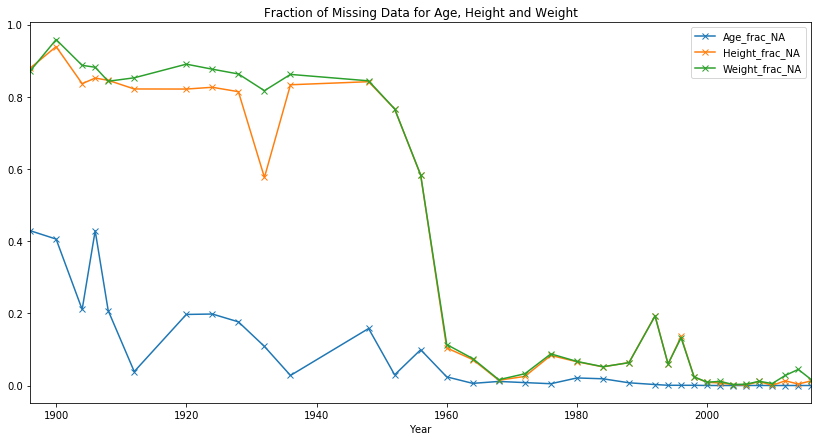

In [85]:
grouped[['Age_frac_NA','Height_frac_NA', 'Weight_frac_NA']].plot(marker='x', figsize=(14,7),
                                                 title='Fraction of Missing Data for Age, Height and Weight')
plt.show()

__Observe:__

- Prior to 1960 the fraction of missing Weight and Height data is too large to warrant meaningful analysis using this features. 
- The proportion of missing Age data is less then Weight and Height data, but is is still substantial. 

Depending on the purpose for which the cleaned dataset is intended, there could be value in dropping history before 1964 and only using the more complete values (from 1964 onwards) for analysis. Alternatively, the entire history could be kept but making conclusions resting on the Age, Weight and Height, should be done with care and consideration for the amount of data missing. 

__Action:__ Prepare a 'robust' data set, which will make the best possible attempt at 'filling in the gaps' while also keeping the entire history. Average Age, Height and Weight will be found for each sport category, gender and year. This will then be used to fill relevant NaNs. The choice to calculate means based on the sport/gender/year split is dictated by: 
 - Fact that for different spots athletes body metrics vary. For instance swimmers tend to be tall while gymnasts are shorter.  
 - Fact that there are clear body-metric differences between the sexes.
 - Fact that there is a trend for Age/Height/Weight to vary with time. 

As far as the Weight category, there is one shortcoming of the above method when a sport discipline has certain weight categories, for instance in boxing and wrestling. Instead of assigning all boxing/wrestling NaN weights to an average for the sport it would be better to look at the event column and extract the precise weight category. Then, weight averaging could be done on those categories. This was not undertaken, since for the purpose of further analysis it was not deemed essential.

In [86]:
# # THIS CODE FILLS NANs AS DESCRIBED ABOVE
#
# # make a multi-level dictionary to loop over all average values to fillna 
# master_dict = {'Height' : merged.groupby(['Sport', 'Sex','Year'])['Height'].mean().unstack().to_dict(),
#                'Weight' : merged.groupby(['Sport', 'Sex','Year'])['Weight'].mean().unstack().to_dict(),
#                'Age' : merged.groupby(['Sport', 'Sex','Year'])['Age'].mean().unstack().to_dict()}

# for key1 in master_dict: # values: Height/Weight/Age
#     for key2 in master_dict[key1]: # values: Year
#         for key3 in  master_dict[key1][key2]: # values:(Sport,Sex)
#             merged.loc[(merged[key1].isnull()) & (merged['Year'] == key2) & (merged['Sport'] == key3[0])& 
#                        (merged['Sex'] == key3[1]),key1] = master_dict[key1][key2][key3]
#
# # save cleaned data frame
# merged.to_csv('clean_data.csv')

In [43]:
# LOAD cleaned data frame, to avoid running code commented above, which takes a while.... 
clean_data = pd.read_csv('all_data/clean_data.csv')

In [44]:
clean_data.isnull().sum() 

Unnamed: 0       0
ID               0
Name             0
Sex              0
Age              3
Height        2276
Weight        6202
Team             0
NOC              0
Games            0
Year             0
Season           0
City             0
Sport            0
Event            0
Medal            0
Country          0
dtype: int64

In [45]:
assert ( clean_data[clean_data.Year > 1964].isnull().sum().sum() == 0 )

Result: No more NaNs in Age column, and a significant reductuion in NaNs in Height and Weight columns; 
 - Height had 58814 NaNs now only 2276, which is less then 4% of the orignal missing values. 
 - Weight had 61527 NaNs now only 6202, which is 10% of the orignal missing values. 
All Height and Weight data still Missing is from before 1964, thsi are cases where there was no data to an average from, ie.e all athletes in the categor had NaN Weight and Height.

I will leave the reminiang NaNs as is for now, as they will not have a bearing on my future analysis 